In [1]:
from bokeh.layouts import gridplot
from bokeh.models import BoxSelectTool, LassoSelectTool, HoverTool, Span, ColumnDataSource, ColorBar, LinearColorMapper
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, output_file
from bokeh.palettes import Greys256

In [2]:
import pybar.pybar_tom as pybar
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib import cm
from matplotlib import colorbar
import pandas as pd
from tqdm import tqdm
import functions as f
from pathlib import Path
import time

In [3]:
beta = np.deg2rad(50)
i    = np.deg2rad(45)
to_Myr = 9.78462
bar_length = 2.6
err_vr = 0.1
err_rho = 0.05
t = 20
step_final = 0.1
case = 'strongbar'
X, Y, VX, VY, RHO = np.load(f'./../simulation/simulation/output_npy/{case}/data_{t}.npy')
FIG_DIR = Path('./figures/')

X, Y, VX, VY = f.rotate_bar(beta, X, Y, VX, VY)
VX, VY = f.add_solid_body_rotation(X, Y, VX, VY, 0.4)
X, Y, VR = f.incline_galaxy(i, X, Y, VX, VY)

RHO_array = RHO.copy()
VR_array  = VR.copy()
x_center_array, y_center_array = X.copy(), Y.copy()

VR_err = err_vr * np.ones_like(VR_array)
RHO_err = err_rho * RHO_array

# VR_array, RHO_array = f.add_uncertanties(VR_array, RHO_array, err_vr, err_rho * RHO_array)

bar = pybar.mybar(Flux=RHO_array, Flux_err=RHO_err,
                  Velocity=VR_array, Velocity_err=VR_err,
                  Yin=y_center_array, Xin=x_center_array,
                  slit_width=step_final,
                  inclin=np.rad2deg(i), PAnodes=-90, beta=np.rad2deg(beta), if_symmetrize=False)

bar.tremaine_weinberg()
omega_bar, omega_bar_err, c, c_err, x_tw, v_tw, x_tw_err, v_tw_err, mask = f.fit(bar)

plasma = cm.get_cmap('plasma', len(x_tw))
colors = plasma.colors

x_fit = np.linspace(np.nanmin(x_tw), np.nanmax(x_tw), 3)
y_GT  = (x_fit * 40) * np.sin(i) + c * 100
y_fit = (x_fit * omega_bar * 100) + c * 100

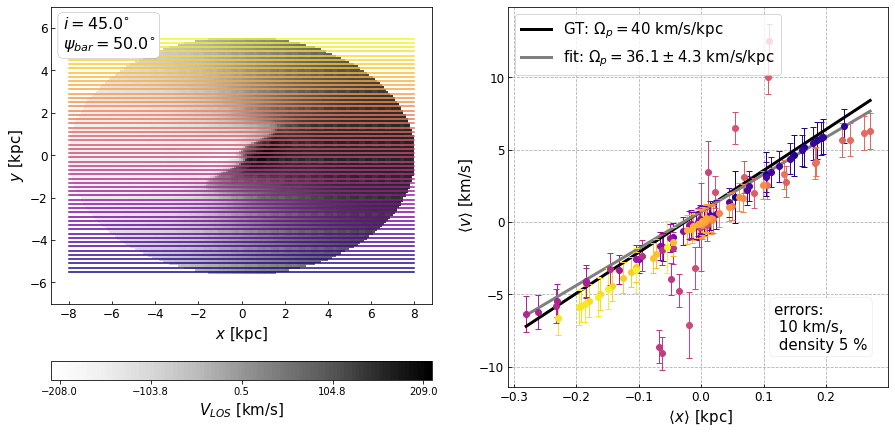

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

levels = np.linspace(np.nanmin(VR) * 100 - 10, np.nanmax(VR) * 100 + 10, 101)
cbarticks = np.linspace(np.nanmin(VR).round(2) * 100 , np.nanmax(VR).round(2) * 100 , 5)
norm = mc.BoundaryNorm(levels, 256)

ax1 = ax[0]
ax2 = ax[1]

sc = ax1.scatter(bar.X_lon, bar.Y_lon, c=bar.Vel * 100, 
                 cmap='Greys', norm=norm, marker='s', s=3)
for index, y in enumerate(bar.y_slits):
    if index % 2 == 0:
        ax1.plot([-8, 8], [y, y], c=colors[index])
ax1.set_xlabel(r'$x$ [kpc]', fontsize=15)
ax1.set_ylabel(r'$y$ [kpc]', fontsize=15)
ax1.tick_params(labelsize=12, direction='in')
ax1.annotate(r'$i=%.1f ^{\circ}$' % (np.rad2deg(i)) + '\n' + r'$\psi_{bar}=%.1f ^{\circ}$' % (np.rad2deg(beta)),
             xy=(0.03, 0.86), xycoords='axes fraction', fontsize=16, color='k', 
             bbox=dict(boxstyle="round", fc="w", ec="gray", lw=0.3))


ax1.set_ylim(-7, 7)
cbar = plt.colorbar(sc, ax=ax1, orientation="horizontal", fraction=0.07, ticks=cbarticks)
cbar.set_label(label=r'$V_{LOS}$ [km/s]', size=15)

ax2.plot(x_fit, y_GT,
        c='black', lw=3, label=r'GT: $\Omega_p = 40$ km/s/kpc')
ax2.plot(x_fit, y_fit, 
        c='gray', lw=3, label=fr'fit: $\Omega_p = {(omega_bar * 100 / np.sin(i)).round(1)} \pm {(omega_bar_err * 100 / np.sin(i)).round(1)} $ km/s/kpc')

for x, y, e1, e2, color in zip(x_tw, v_tw * 100, x_tw_err, v_tw_err * 100, colors):
    ax2.errorbar(x, y, xerr=e1, yerr=e2, lw=1, capsize=3, color=color, marker='o')

ax2.annotate(f'errors: \n {int(err_vr * 100)} km/s, \n density {int(err_rho * 100)} %',
            xy=(0, 0.5),
            xycoords='axes fraction',
            xytext=(0.7, 0.1), fontsize=15,  
            bbox=dict(boxstyle="round", fc="w", ec="gray", lw=0.1))

ax2.tick_params(labelsize=12,direction='in')
ax2.set_xlabel(r' $\langle x \rangle$ [kpc]', fontsize=15)
ax2.set_ylabel(r' $\langle v \rangle$ [km/s]', fontsize=15)
ax2.legend(fontsize=15, loc='upper left')

ax2.grid(ls='dashed')
#plt.savefig(FIG_DIR / f'TW_method_pybar_strongbar.png', bbox_inches='tight', dpi=300)

In [5]:
output_file("twm2D.html")
# output_notebook

TOOLS="reset, zoom_in"
# create a column data source for the plots to share
colors[:, 0:3] *= 255

source_left = ColumnDataSource(data=dict(x=bar.X_lon, y=bar.Y_lon, v=bar.Vel * 100))
source = ColumnDataSource(data=dict(x0=np.zeros_like(bar.y_slits), 
                                    x1=np.ones_like(bar.y_slits) * -7,
                                    x2=np.ones_like(bar.y_slits) * -5,
                                    x3=np.ones_like(bar.y_slits) * -3,
                                    x4=np.ones_like(bar.y_slits) * -1,
                                    x5=np.ones_like(bar.y_slits) *  1,
                                    x6=np.ones_like(bar.y_slits) *  3,
                                    x7=np.ones_like(bar.y_slits) *  5,
                                    x8=np.ones_like(bar.y_slits) *  7,
                                    y_slits=bar.y_slits, 
                                    x_tw=x_tw, v_tw=v_tw * 100,
                                   color=tuple((colors).astype('uint32'))))

#################################### create the left ###############################################
p = figure(tools=TOOLS, width=400, height=400, min_border=10, min_border_left=50,
           toolbar_location="above", x_range=(-8, 8),# y_range=(-8, 8),
           title="TWM applied to 2D simulation", x_axis_label='x [kpc]', y_axis_label='y [kpc]',
           aspect_scale=1)
p.background_fill_color = "#fafafa"

color_map = LinearColorMapper(palette = list(reversed(Greys256)),
                              low=np.nanmin(bar.Vel * 100), high=np.nanmax(bar.Vel * 100))
r = p.scatter('x', 'y', color={'field': 'v', 'transform': color_map},source=source_left,#color=(bar.Vel * 100).astype('uint32'),
              size=3, line_color=None, alpha=1)
p.add_tools(BoxSelectTool(names=['slits']))

for index, y in enumerate(bar.y_slits):
    if index % 4 == 0:
        p.line([-8, 8], [y, y], color=tuple((colors[index]).astype('uint32')[:3]), line_width=2)

r = p.scatter('x0', 'y_slits',  source=source,  name='slits', color='black', size=0.5, alpha=0)
r = p.scatter('x1', 'y_slits',  source=source,  name='slits', color='black', size=0.5, alpha=0)
r = p.scatter('x2', 'y_slits',  source=source,  name='slits', color='black', size=0.5, alpha=0)
r = p.scatter('x3', 'y_slits',  source=source,  name='slits', color='black', size=0.5, alpha=0)
r = p.scatter('x4', 'y_slits',  source=source,  name='slits', color='black', size=0.5, alpha=0)
r = p.scatter('x5', 'y_slits',  source=source,  name='slits', color='black', size=0.5, alpha=0)
r = p.scatter('x6', 'y_slits',  source=source,  name='slits', color='black', size=0.5, alpha=0)
r = p.scatter('x7', 'y_slits',  source=source,  name='slits', color='black', size=0.5, alpha=0)
r = p.scatter('x8', 'y_slits',  source=source,  name='slits', color='black', size=0.5, alpha=0)

color_bar = ColorBar(color_mapper=color_map, title=r'Line-of-sight Velocity [km/s]', title_standoff=5)

p.add_layout(color_bar, 'below')

######################################## create the right ##########################################

pr = figure(toolbar_location=None, width=400, height=400, min_border=10, min_border_left=50,
            x_range=(-0.5, 0.5), y_range=(-12, 12), y_axis_location="left",
            x_axis_label='< x > [kpc]', y_axis_label='< v > [km/s]')
pr.background_fill_color = "#fafafa"
pr.select(BoxSelectTool).select_every_mousemove = False
pr.select(LassoSelectTool).select_every_mousemove = False

pr.line(x_fit, y_GT, color='black', legend_label='GT Omega', line_width=3)
pr.line(x_fit, y_fit, color='gray', legend_label='Measured Omega', line_width=3)
pr.legend.location = "top_left"

pr.scatter('x_tw', 'v_tw',source=source, color='color', size=5)

layout = gridplot([[p, pr]], merge_tools=False)

show(layout)